In [1]:
!nvidia-smi
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  
print("GPU Details:", tf.config.list_physical_devices('GPU'))


Thu Jan 22 16:12:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.195.03             Driver Version: 570.195.03     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   45C    P5              4W /   55W |     609MiB /   8188MiB |     20%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

2026-01-22 16:12:37.479343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0
Num GPUs Available:  1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from load_dataset import load_dataset
train_gen, val_gen, train_gen_class_indc = load_dataset(batch_size=128)

Found 33240 images belonging to 8 classes.
Found 8306 images belonging to 8 classes.


# Testing dataset on sample CNN

In [ ]:
from tensorflow.keras import layers, models

def build_spatial_core(num_classes=8):
    inp = layers.Input(shape=(None, None, 3))

    x = layers.Conv2D(32, 3, activation="relu")(inp)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 3, activation="relu")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, 26, activation="relu")(x)
    out = layers.Conv2D(num_classes, 1)(x)   # (h,w,8)

    return models.Model(inp, out, name="spatial_core")

In [4]:
def build_training_model(spatial_core, num_classes=8):
    inp = layers.Input(shape=(224, 224, 3))   # fixed for generator
    x = spatial_core(inp)                     # (1,1,8)
    x = layers.GlobalAveragePooling2D()(x)    # (8)
    out = layers.Activation("softmax")(x)
    return models.Model(inp, out, name="training_model")


In [5]:
spatial_core = build_spatial_core(num_classes=8)
train_model = build_training_model(spatial_core, num_classes=8)


I0000 00:00:1769078560.211565   21401 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5568 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
spatial_core.summary()

Model: "spatial_core"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, None, None, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, None, None, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, None, None, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, None, None,     │    11,075,712 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 8)  │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,992 (42.61 MB)

 Trainable params: 11,169,992 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
train_model.summary()

Model: "training_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_core (Functional)       │ (None, 1, 1, 8)        │    11,169,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 8)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 8)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,992 (42.61 MB)

 Trainable params: 11,169,992 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
train_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [9]:
history = train_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size
)

2026-01-22 16:13:25.090159: I external/local_xla/xla/service/service.cc:163] XLA service 0x7780a8006540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-22 16:13:25.090184: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-22 16:13:25.114799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-22 16:13:25.284826: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-22 16:13:34.176890: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng1{k2=3,k3=0} for conv (f32[128,128,26,26]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,128,1,1]{3,2,1,0}, f32[128,128,26,26]{3,2,1,0}), window={size=26x26}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", bac

  1/259 ━━━━━━━━━━━━━━━━━━━━ 1:31:00 21s/step - accuracy: 0.0469 - loss: 2.0976

I0000 00:00:1769078624.073033   21570 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  7/259 ━━━━━━━━━━━━━━━━━━━━ 3:44 890ms/step - accuracy: 0.1582 - loss: 2.0053

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


174/259 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.2715 - loss: 1.8394

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


259/259 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.3348 - loss: 1.7312 - val_accuracy: 0.3365 - val_loss: 1.7347


In [19]:
history = train_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_steps=val_gen.samples // val_gen.batch_size
)

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
222/259 ━━━━━━━━━━━━━━━━━━━━ 35s 967ms/step - accuracy: 0.4018 - loss: 1.6023

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


259/259 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.4068 - loss: 1.5770 - val_accuracy: 0.3544 - val_loss: 1.6581
Epoch 2/20
  1/259 ━━━━━━━━━━━━━━━━━━━━ 55s 215ms/step - accuracy: 0.4766 - loss: 1.4535

/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


259/259 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.4766 - loss: 1.4535 - val_accuracy: 0.3475 - val_loss: 1.6581
Epoch 3/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.4392 - loss: 1.4973 - val_accuracy: 0.3816 - val_loss: 1.6455
Epoch 4/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.4688 - loss: 1.4393 - val_accuracy: 0.3770 - val_loss: 1.6468
Epoch 5/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 280s 1s/step - accuracy: 0.4600 - loss: 1.4485 - val_accuracy: 0.3854 - val_loss: 1.6466
Epoch 6/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - accuracy: 0.5312 - loss: 1.3311 - val_accuracy: 0.3855 - val_loss: 1.6495
Epoch 7/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.4828 - loss: 1.3985 - val_accuracy: 0.3894 - val_loss: 1.6447
Epoch 8/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 30s 117ms/step - accuracy: 0.4531 - loss: 1.4824 - val_accuracy: 0.4001 - val_loss: 1.6446
Epoch 9/20
259/259 ━━━━━━━━━━━━━━━━━━━━ 279s 1s/step - accuracy: 0.4952 - loss: 1.3640 - val_accurac

KeyboardInterrupt: 

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

def visualize_spatial_heatmaps(val_gen,spatial_core,class_indices,min_size=224,max_size=448):
    idx_to_class = {v: k for k, v in class_indices.items()}

    # pick random image
    batch_x, _ = val_gen[random.randint(0, len(val_gen) - 1)]
    img = batch_x[random.randint(0, batch_x.shape[0] - 1)]

    # random resize
    h = random.randint(min_size, max_size)
    w = random.randint(min_size, max_size)
    img_rs = cv2.resize(img, (w, h))

    # predict
    preds = spatial_core.predict(img_rs[None, ...], verbose=0)[0]  # (m,n,C)

    # setup grid
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # original image
    axes[0].imshow(img_rs)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # heatmaps
    for c in range(preds.shape[-1]):
        heat = preds[:, :, c]
        heat = cv2.resize(heat, (w, h))

        axes[c + 1].imshow(heat, cmap="hot")
        axes[c + 1].set_title(idx_to_class[c])
        axes[c + 1].axis("off")

    # hide unused cells (if any)
    for i in range(preds.shape[-1] + 1, 9):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


2026-01-22 17:16:20.422826: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-22 17:16:20.506712: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


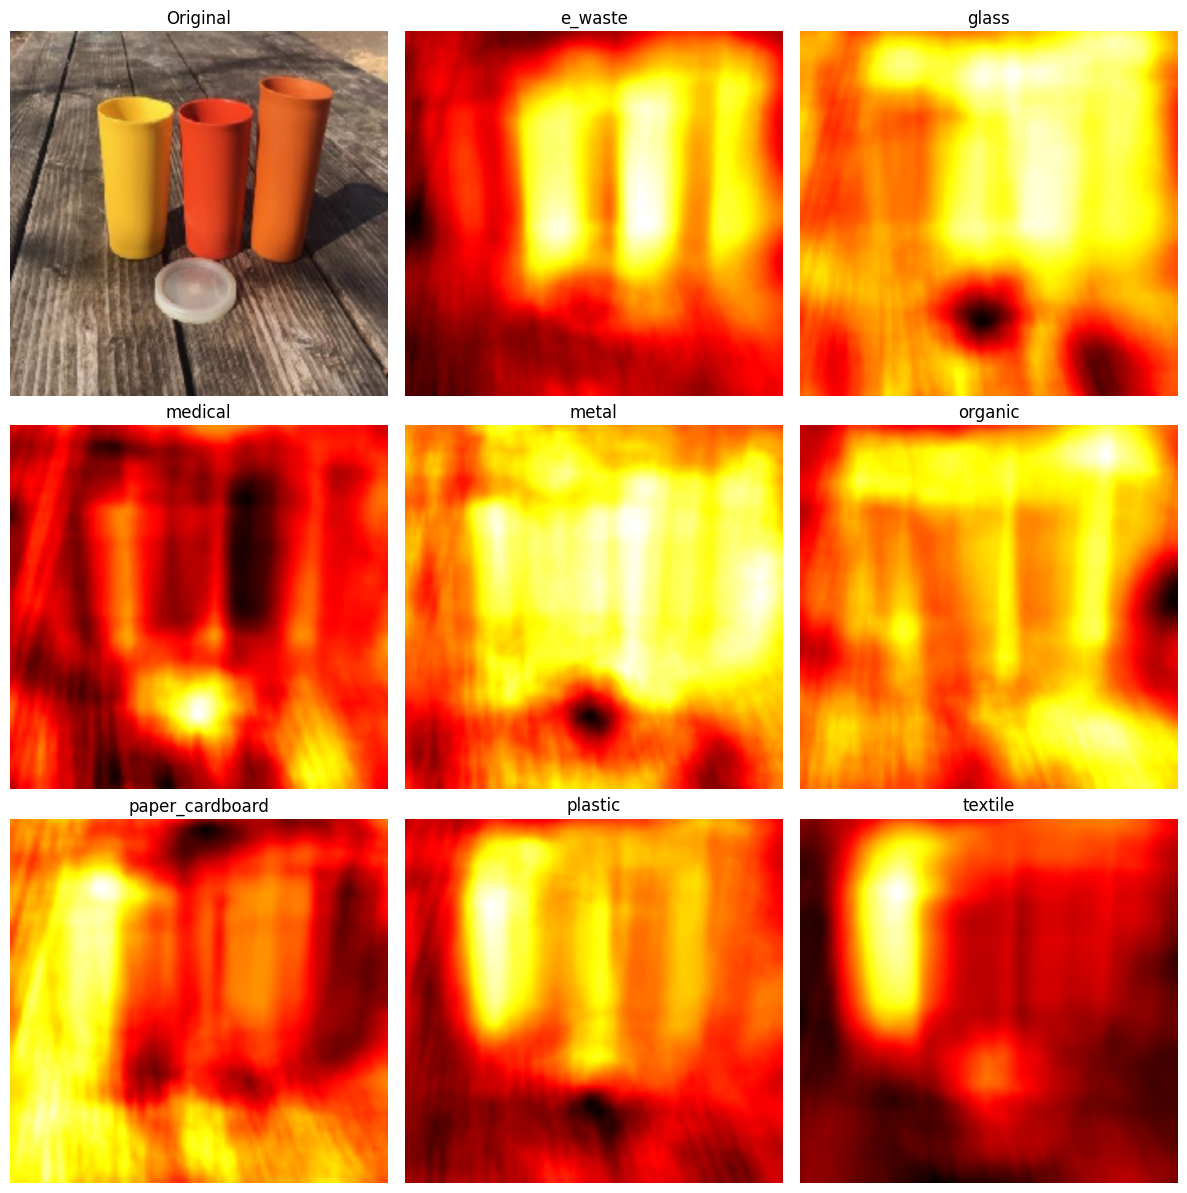

In [91]:
visualize_spatial_heatmaps(
    val_gen,
    spatial_core,
    class_indices=train_gen_class_indc,
    min_size=600,
    max_size=1024
)


In [ ]:
# spatial_core.save("spatial_core_model.h5")
# train_model.save("train_model.h5")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

def visualize_grid_overlays(val_gen,spatial_core,class_indices,min_size=224,max_size=448,threshold=0.4,alpha=0.6):
    idx_to_class = {v: k for k, v in class_indices.items()}
    num_classes = len(class_indices)

    COLORS = [
        (255, 0, 0), (0, 255, 0), (0, 0, 255),
        (255, 255, 0), (255, 0, 255), (0, 255, 255),
        (255, 128, 0), (128, 0, 255)
    ]

    # pick random image + label
    bx, by = val_gen[random.randint(0, len(val_gen) - 1)]
    i = random.randint(0, bx.shape[0] - 1)
    img = bx[i]
    true_class = idx_to_class[np.argmax(by[i])]

    # random resize
    H = random.randint(min_size, max_size)
    W = random.randint(min_size, max_size)
    img_rs = cv2.resize(img, (W, H))

    # predict
    preds = spatial_core.predict(img_rs[None, ...], verbose=0)[0]  # (m,n,C)

    # setup grid
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # plot original
    axes[0].imshow(img_rs)
    axes[0].set_title(f"Original (true: {true_class})")
    axes[0].axis("off")

    # plot each class overlay
    for c in range(num_classes):
        heat = cv2.resize(preds[:, :, c], (W, H))
        heat = np.clip(heat, 0, 1)

        mask = heat > threshold
        color = np.array(COLORS[c % len(COLORS)]) / 255.0

        overlay = img_rs.copy()
        for k in range(3):
            overlay[:, :, k] = np.where(
                mask,
                (1 - alpha) * overlay[:, :, k] + alpha * heat * color[k],
                overlay[:, :, k]
            )

        axes[c + 1].imshow(overlay)
        axes[c + 1].set_title(idx_to_class[c])
        axes[c + 1].axis("off")

    # hide unused cells if any
    for j in range(num_classes + 1, 9):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


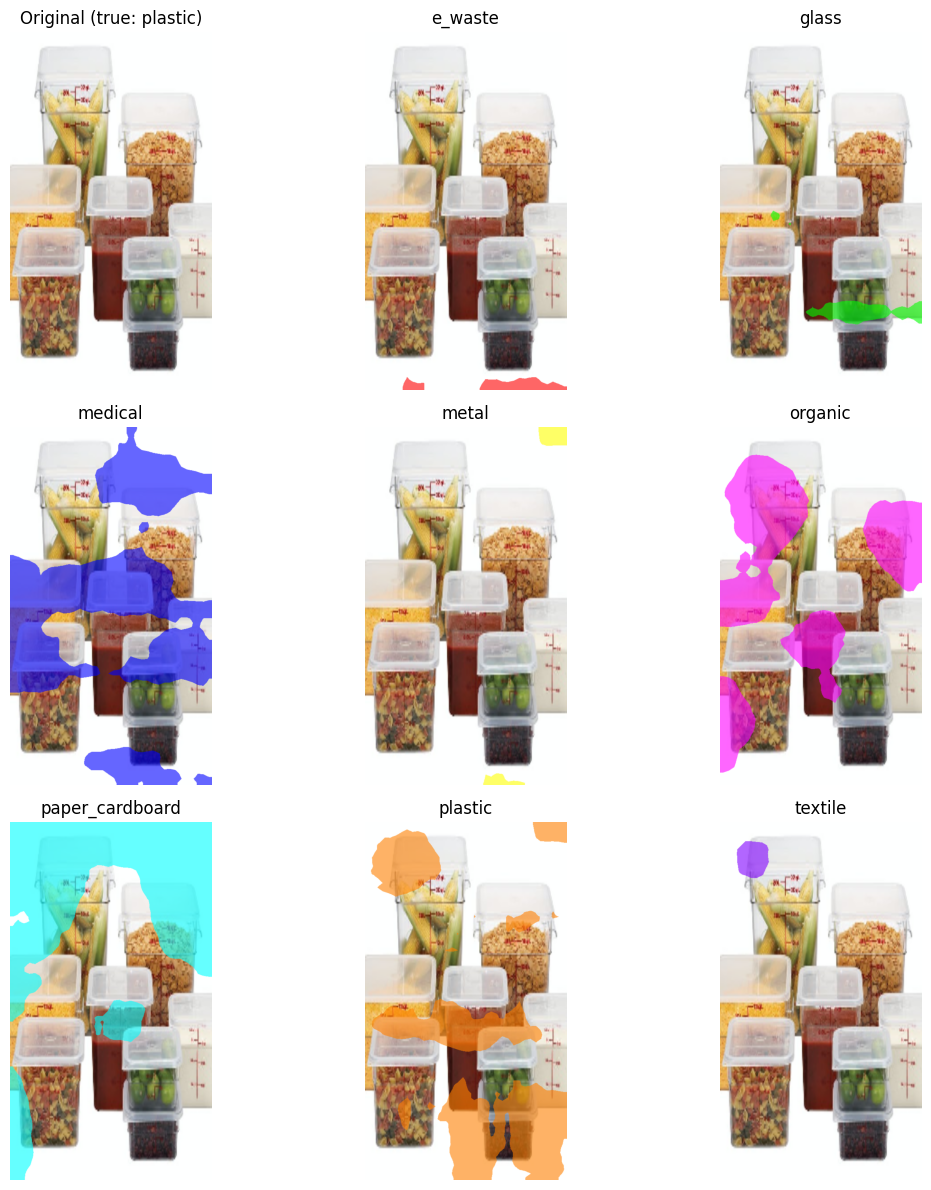

In [92]:
visualize_grid_overlays(
    val_gen,
    spatial_core,
    class_indices=train_gen_class_indc,
    threshold=0.99,
    min_size=447,
    max_size=1024,
    alpha=0.6
)


In [93]:
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

def visualize_color_heatmap_grid(val_gen,spatial_core,class_indices,min_size=224,max_size=448,cmap="jet"):
    idx_to_class = {v: k for k, v in class_indices.items()}
    num_classes = len(class_indices)

    # pick random image + label
    bx, by = val_gen[random.randint(0, len(val_gen) - 1)]
    i = random.randint(0, bx.shape[0] - 1)
    img = bx[i]
    true_class = idx_to_class[np.argmax(by[i])]

    # random resize
    H = random.randint(min_size, max_size)
    W = random.randint(min_size, max_size)
    img_rs = cv2.resize(img, (W, H))

    # predict
    preds = spatial_core.predict(img_rs[None, ...], verbose=0)[0]  # (m,n,C)

    # grid
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    # original
    axes[0].imshow(img_rs)
    axes[0].set_title(f"Original (true: {true_class})")
    axes[0].axis("off")

    # class heatmaps
    for c in range(num_classes):
        heat = preds[:, :, c]
        heat = cv2.resize(heat, (W, H))
        heat = (heat - heat.min()) / (heat.max() - heat.min() + 1e-6)

        axes[c + 1].imshow(heat, cmap=cmap)
        axes[c + 1].set_title(idx_to_class[c])
        axes[c + 1].axis("off")

    # hide unused cells
    for j in range(num_classes + 1, 9):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


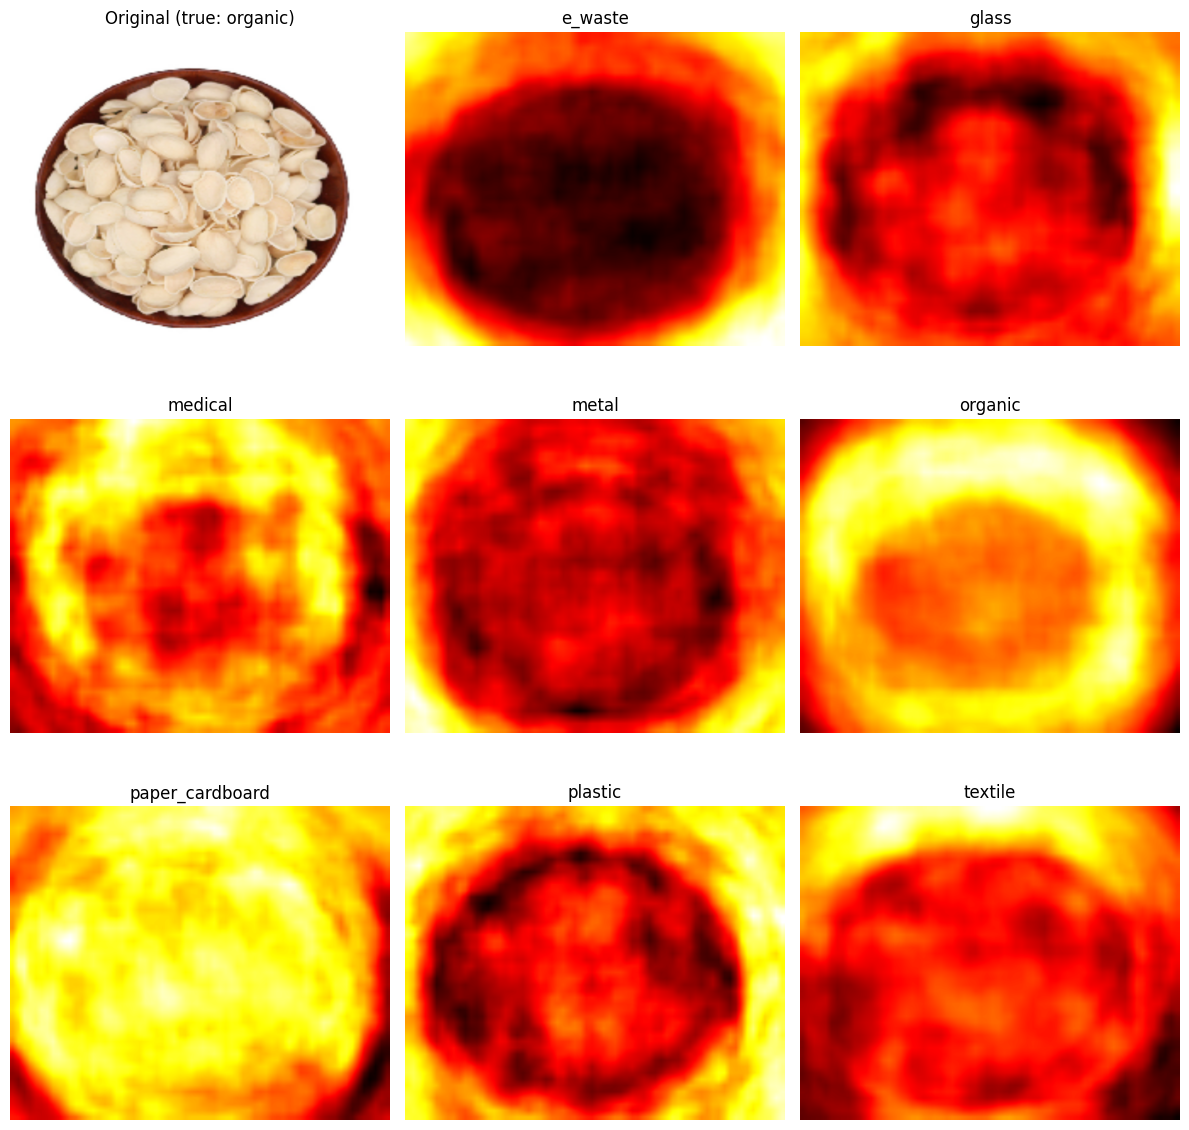

In [ ]:
visualize_color_heatmap_grid(
    val_gen,
    spatial_core,
    min_size=600,
    max_size=1024,
    class_indices=train_gen_class_indc,
    cmap="hot"   # try: "hot", "inferno", "magma", "jet"
)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    hist = history.history

    plt.figure(figsize=(14,4))

    # Accuracy
    plt.subplot(1,3,1)
    plt.plot(hist.get("accuracy", []), label="train")
    plt.plot(hist.get("val_accuracy", []), label="val")
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,3,2)
    plt.plot(hist["loss"], label="train")
    plt.plot(hist["val_loss"], label="val")
    plt.title("Loss")
    plt.legend()

    # Learning rate (if present)
    if "lr" in hist:
        plt.subplot(1,3,3)
        plt.plot(hist["lr"])
        plt.title("Learning Rate")

    plt.tight_layout()
    plt.show()


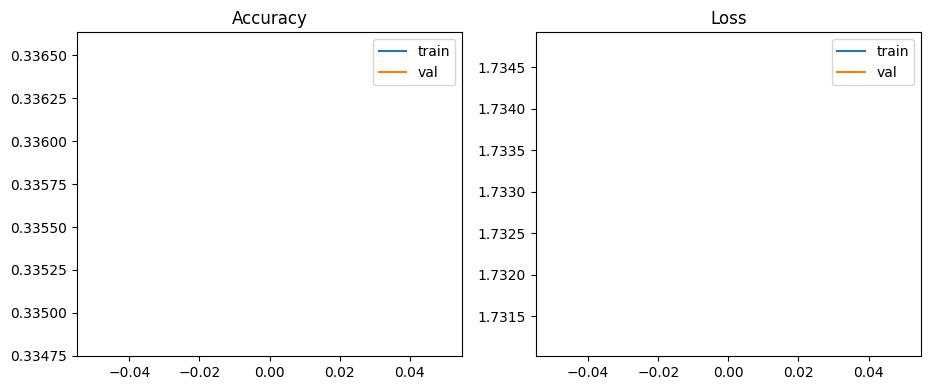

In [98]:
plot_training_history(history)

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, val_gen, class_indices):
    y_true = []
    y_pred = []

    for i in range(len(val_gen)):
        x, y = val_gen[i]
        preds = model.predict(x, verbose=0)

        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    labels = list(class_indices.keys())
    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


/home/vector/anaconda3/envs/gpu/lib/python3.11/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


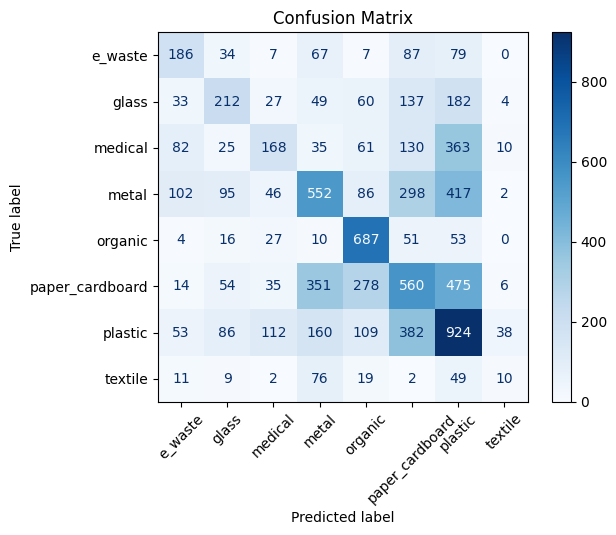

In [104]:
plot_confusion_matrix(train_model, val_gen, train_gen_class_indc)


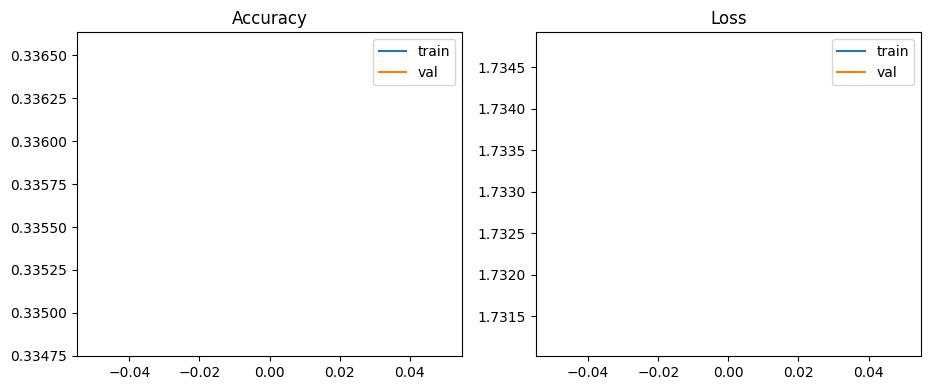

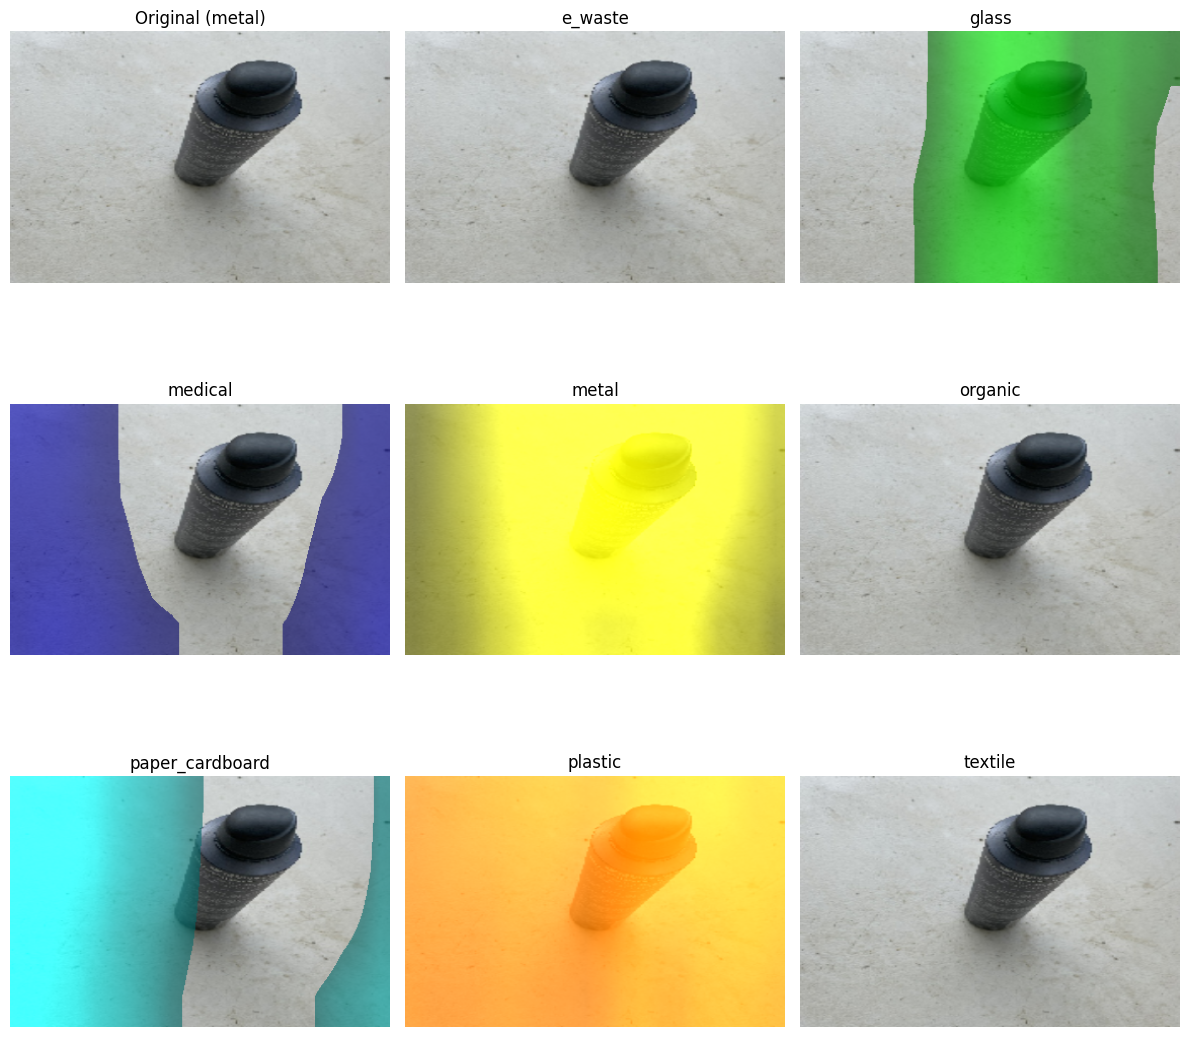

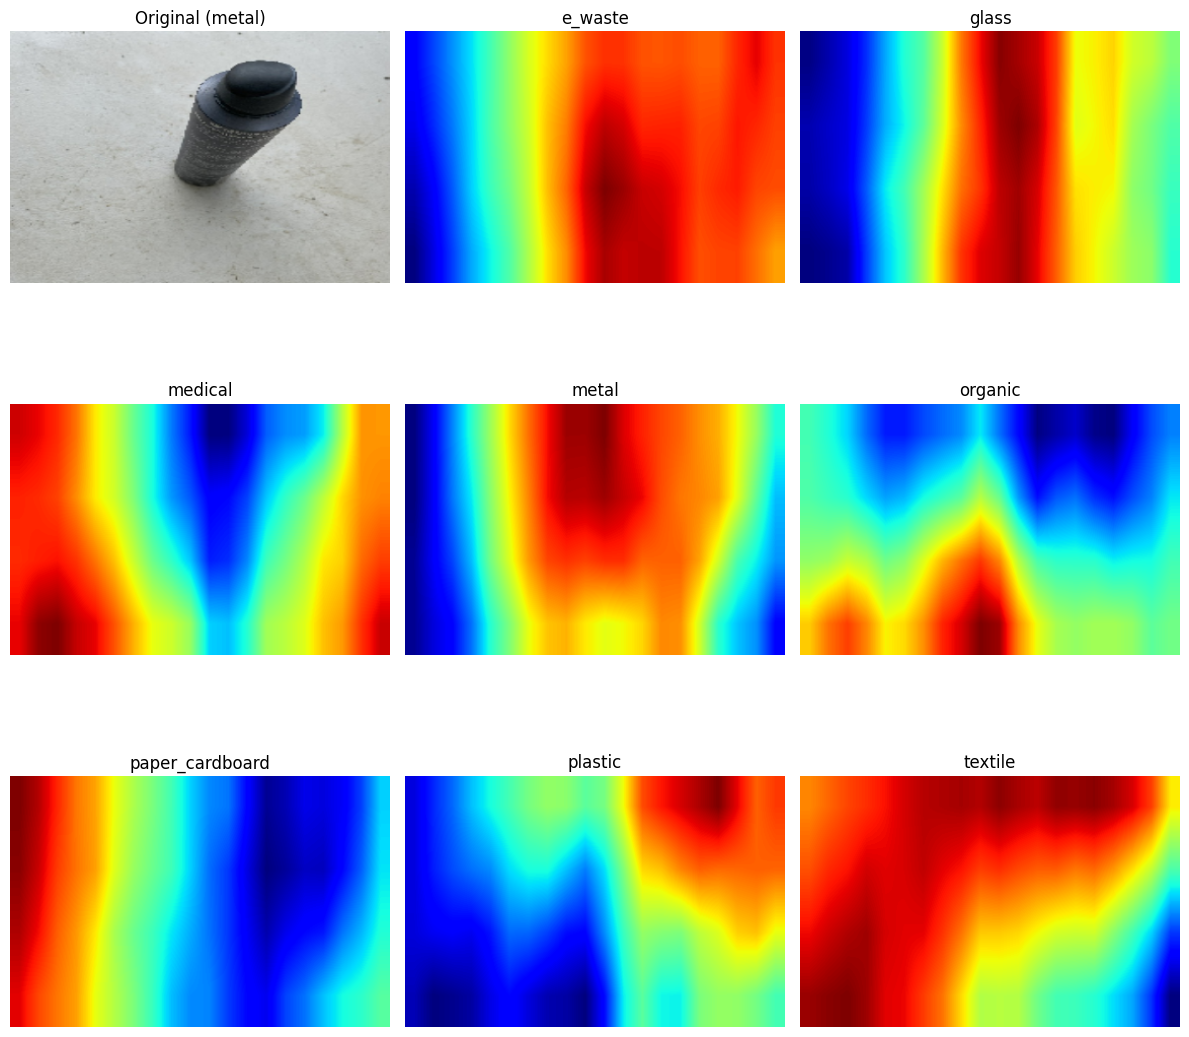

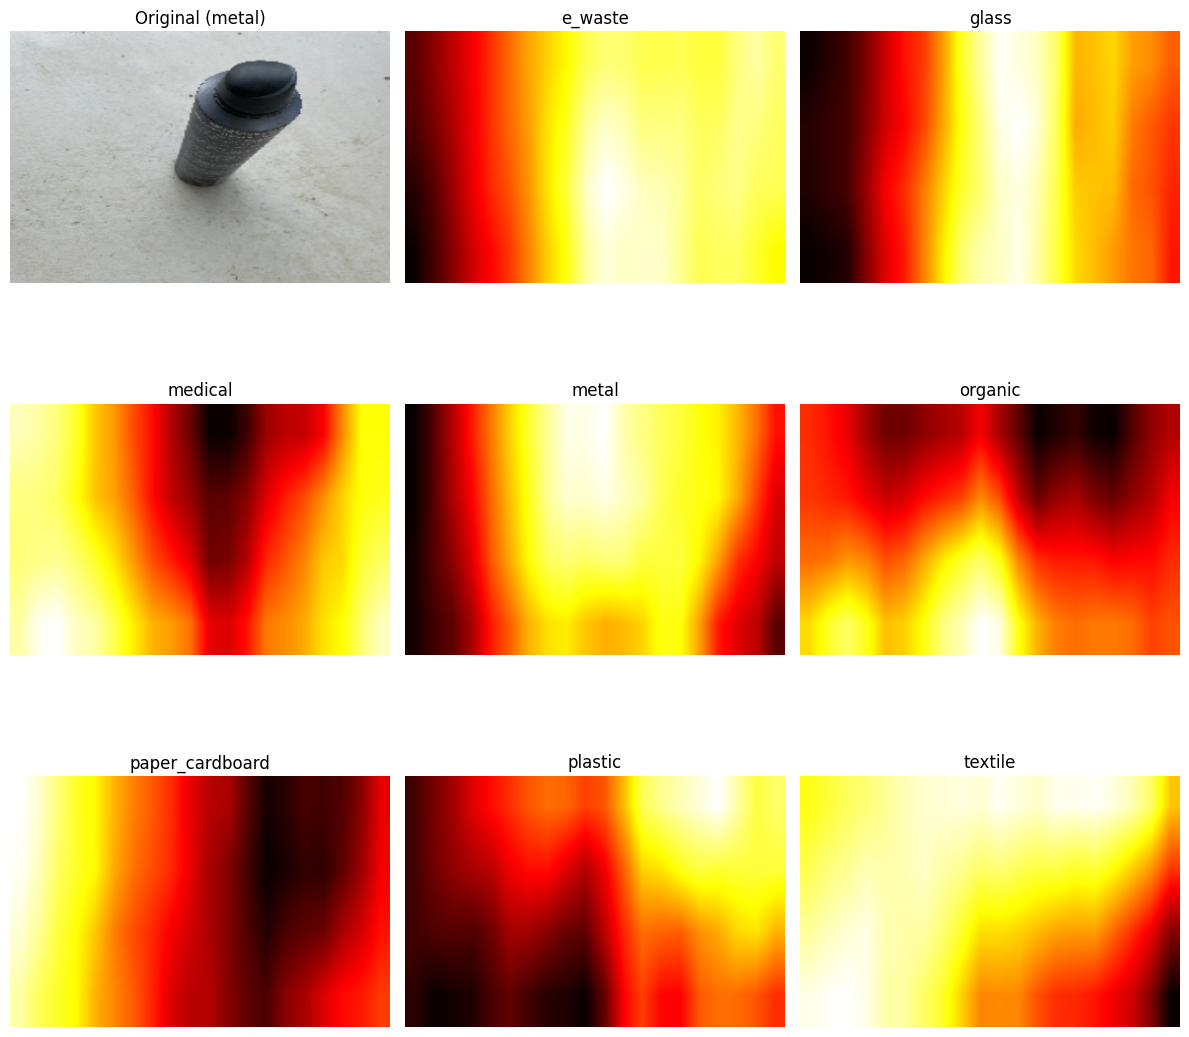

In [ ]:
# assume these already exist
# train_model   -> model used for training / classification
# spatial_core  -> sliding FCN (same weights)
# history       -> returned by model.fit(...)
# val_gen       -> validation ImageDataGenerator
# class_indices -> from train_gen.class_indices

from test_model import ModelTester

tester = ModelTester(model=train_model,history=history,val_gen=val_gen,class_indices=train_gen_class_indc)

# training diagnostics
tester.plot_history()
# tester.plot_confmat()

# spatial diagnostics (ONE image, all plots)
tester.show_all(spatial_core)
